In [1]:
"""
The codes perform pre-processing of multiples .txt files.
Then the text data is compared against 2 word lists representing innovation and risk-taking in organization, and a vector is
generated for each document showing existence of each word in the document. The data is used for clustering, using K-means
clustering algorithm

Provided by: Amin
"""

#pip install nltk
#nltk.download('stopwords')
#nltk.download('wordnet')

import glob
import os
import string
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Read .txt files

Data = {}
for file in glob.glob('*.txt'):
    with open(file, 'r', encoding= 'utf-8') as f:
        Data[file.split('.')[0]] = f.read()

In [3]:
#Pre-processing data

names = Data.keys()
Data_prep = {}
punc = set(string.punctuation)
from nltk.corpus import stopwords
stop = stopwords.words('english')
for i in names:
    lower = Data[i].lower() #lower case words
    num_free = ''.join(x for x in lower if not x.isdigit()) #remove digits
    punc_free = ''.join(x for x in num_free if x not in punc) #remove punctuation
    stop_free = ' '.join(x for x in punc_free.split() if x not in stop) #remove stopwords
    Data_prep[i] = stop_free
    
docs_df = pd.DataFrame(Data_prep, index=['text']).T

docs_df['Country'] = list(docs_df.reset_index()['index'].apply(lambda x: re.split('-|_', x)[0]))
docs_df['Bank'] = list(docs_df.reset_index()['index'].apply(lambda x: re.split('-|_', x)[1]))
docs_df['Message'] = list(docs_df.reset_index()['index'].apply(lambda x: re.split('-|_', x)[2]))
docs_df['Year'] = list(docs_df.reset_index()['index'].apply(lambda x: re.split('-|_', x)[3]))

docs_df_new = docs_df.groupby(by=['Country', 'Bank', 'Year']).sum().drop(columns= 'Message')

In [5]:
docs_df_new.head()

text
Country Bank Year                                                   
BHR     ABC  2010  chairman’s statement view adverse market condi...
             2011  directors’ report figures us dollars name alla...
             2012  directors’ report figures us dollars name alla...
             2013  directors’ report name allah beneficent mercif...
             2014  directors’ report net proﬁt showed healthy inc...

## Clustering documents based on 2 word lists

In [6]:
# Creat word lists
innove_dict = ['adroit*', 'bright(-| )idea', 'change', 'clever*', 'conceive', 'concoct*', 'conjure', 'creat*', 'creativ*',
               'creator', 'discover*', 'discovery', 'dream*', 'envision', 'envisage', 'expert*', 'formulation', 'frame',
               'freethinker', 'genesis', 'genius', 'gifted', 'hit(-| )upon', 'imagine', 'imaginat*', 'improvise', 'ingenious',
               'ingenuity', 'initiat*', 'innovat*', 'innovation', 'inspir*', 'invent*', 'inventor', 'master(-| )stroke',
               'mastermind', 'metamorphos*', ' neoter*', ' new', 'novel*', 'original', 'originat*', 'patent', 'radical',
               'recast', 'research', 'resourceful', 'restyl*', 'revolutionize', 'see things', 'think*', 'trademark',
               'vision', 'visualize', 'technology']

risk_dict = ['adventur*', 'audacious', ' bet', ' bold', 'brash', 'brave*', 'chance', 'chancy', 'courag*', 'danger*', ' dare',
             'daring', 'dauntless', ' dicey', 'enterprising', 'fearless', 'gambl*', 'gutsy', 'headlong', 'incautious',
             'intrepid', 'plunge', 'precarious', ' rash', 'reckless', 'risk*', 'spirited', 'temerity', 'uncertain', 'venture',
             'venturesome', ' wager']

In [7]:
#Innovation

word_df_innov = pd.DataFrame(index=docs_df_new.index, columns=innove_dict)
for ind in docs_df_new.index:
    for pattern in innove_dict:
        if re.search(pattern, docs_df_new.loc[ind, 'text'])==None:
            word_df_innov.loc[ind, pattern] = 0
        else:
            word_df_innov.loc[ind, pattern] = 1
            
word_df_innov['%Total'] = word_df_innov[innove_dict].sum(axis=1)/len(innove_dict)

# Clustering the banks to innovative and non-innovative

km_innov = KMeans(n_clusters=2, init='k-means++', random_state=101)
word_df_innov['cluster'] = km_innov.fit_predict(word_df_innov)

print(word_df_innov[word_df_innov['cluster']==1]['%Total'].describe()) #yes innovative
print(word_df_innov[word_df_innov['cluster']==0]['%Total'].describe()) #no innovative

count    247.000000
mean       0.216047
std        0.037341
min        0.127273
25%        0.181818
50%        0.218182
75%        0.236364
max        0.327273
Name: %Total, dtype: float64
count    221.000000
mean       0.115590
std        0.036708
min        0.018182
25%        0.090909
50%        0.127273
75%        0.145455
max        0.200000
Name: %Total, dtype: float64


In [8]:
word_df_innov.head()

adroit* bright(-| )idea change clever* conceive concoct*  \
Country Bank Year                                                            
BHR     ABC  2010       0               0      1       0        0        0   
             2011       0               0      0       0        0        0   
             2012       0               0      0       0        0        0   
             2013       0               0      1       0        0        0   
             2014       0               0      1       0        0        0   

                  conjure creat* creativ* creator  ... restyl* revolutionize  \
Country Bank Year                                  ...                         
BHR     ABC  2010       0      0        0       0  ...       0             0   
             2011       0      1        0       0  ...       0             0   
             2012       0      0        0       0  ...       0             0   
             2013       0      0        0       0  ...       0             0   
             2014       0      1        0       0  ...       0             0   

                  see things think* trademark vision visualize technology  \
Country Bank Year                                                           
BHR     ABC  2010          0      1         0      1         0          0   
             2011          0      1         0      0         0          0   
             2012          0      1         0      1         0          0   
             2013          0      0         0      1         0          0   
             2014          0      0         0      1         0          0   

                     %Total cluster  
Country Bank Year                    
BHR     ABC  2010  0.090909       0  
             2011  0.072727       0  
             2012  0.109091       0  
             2013  0.072727       0  
             2014  0.072727       0  

[5 rows x 57 columns]

In [10]:
#Risk taking

word_df_risk = pd.DataFrame(index=docs_df_new.index, columns=risk_dict)
for ind in docs_df_new.index:
    for pattern in risk_dict:
        if re.search(pattern, docs_df_new.loc[ind, 'text'])==None:
            word_df_risk.loc[ind, pattern] = 0
        else:
            word_df_risk.loc[ind, pattern] = 1
            
word_df_risk['%Total'] = word_df_risk[risk_dict].sum(axis=1)/len(risk_dict)

# Clustering the banks to innovative and non-innovative

km_risk = KMeans(n_clusters=2, init='k-means++', random_state=101)
word_df_risk['cluster'] = km_risk.fit_predict(word_df_risk)

print(word_df_risk[word_df_risk['cluster']==1]['%Total'].describe()) #no risk 
print(word_df_risk[word_df_risk['cluster']==0]['%Total'].describe()) #yes risk

count    216.000000
mean       0.052517
std        0.025836
min        0.000000
25%        0.031250
50%        0.062500
75%        0.062500
max        0.156250
Name: %Total, dtype: float64
count    252.000000
mean       0.106151
std        0.036919
min        0.031250
25%        0.093750
50%        0.093750
75%        0.125000
max        0.218750
Name: %Total, dtype: float64


In [11]:
word_df_risk.head()

adventur* audacious  bet  bold brash brave* chance chancy  \
Country Bank Year                                                             
BHR     ABC  2010         0         0    0     0     0      0      0      0   
             2011         0         0    0     0     0      0      0      0   
             2012         0         0    1     0     0      0      0      0   
             2013         0         0    0     0     0      0      0      0   
             2014         0         0    0     0     0      0      0      0   

                  courag* danger*  ... reckless risk* spirited temerity  \
Country Bank Year                  ...                                    
BHR     ABC  2010       1       0  ...        0     1        0        0   
             2011       1       0  ...        0     1        0        0   
             2012       1       0  ...        0     1        0        0   
             2013       0       0  ...        0     1        0        0   
             2014       1       0  ...        0     1        0        0   

                  uncertain venture venturesome  wager   %Total cluster  
Country Bank Year                                                        
BHR     ABC  2010         1       0           0      0  0.09375       1  
             2011         0       0           0      0  0.06250       1  
             2012         0       0           0      0  0.09375       0  
             2013         0       0           0      0  0.03125       1  
             2014         0       0           0      0  0.06250       1  

[5 rows x 34 columns]

In [14]:
content_df = (pd.concat([word_df_innov[['%Total', 'cluster']], word_df_risk[['%Total', 'cluster']]], axis=1)
              .join(pd.concat([BInnovat_df['cluster'], BRisk_df['cluster']], axis=1), on='Bank', rsuffix='Bank'))
content_df.columns=['Innovat_%Total', 'Innovat_cluster', 'Risk_%Total', 'Risk_cluster', 'BInnov_clus', 'BRisk_clus']

In [15]:
content_df.head()

Innovat_%Total  Innovat_cluster  Risk_%Total  Risk_cluster  \
Country Bank Year                                                               
BHR     ABC  2010        0.090909                0      0.09375             1   
             2011        0.072727                0      0.06250             1   
             2012        0.109091                0      0.09375             0   
             2013        0.072727                0      0.03125             1   
             2014        0.072727                0      0.06250             1   

                   BInnov_clus  BRisk_clus  
Country Bank Year                           
BHR     ABC  2010            1           0  
             2011            1           0  
             2012            1           0  
             2013            1           0  
             2014            1           0

## Plot innovation against risk taking

In [22]:
plot_df = content_df.reset_index().groupby(by=['Country', 'Bank']).mean()

In [23]:
mod = sm.OLS(endog=plot_df['Innovat_%Total'], exog=plot_df['Risk_%Total'], missing='drop')
res = mod.fit()
regres = res.predict(exog=plot_df['Risk_%Total'])
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:         Innovat_%Total   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              1058.
Date:                Wed, 05 Aug 2020   Prob (F-statistic):                    2.24e-39
Time:                        19:57:33   Log-Likelihood:                          107.67
No. Observations:                  60   AIC:                                     -213.3
Df Residuals:                      59   BIC:                                     -211.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

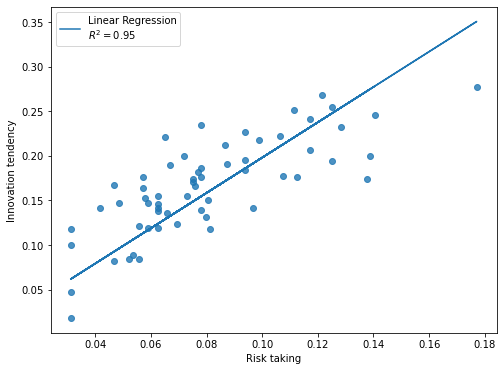

In [24]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(x=plot_df['Risk_%Total'], y=plot_df['Innovat_%Total'], alpha=0.8)
ax.plot(plot_df['Risk_%Total'], regres, label='Linear Regression\n'+r"$R^2=$"+str(np.round(res.rsquared, 2)))
ax.set_xlabel('Risk taking')
ax.set_ylabel('Innovation tendency')
ax.legend(fontsize=10)